# Data 


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap


In [2]:
import os
import pandas as pd

def load_returns_from_folder(folder_path, show_info=True):
    all_returns = {}
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            filepath = os.path.join(folder_path, filename)

            df = pd.read_csv(filepath)

            # Ensure Date is datetime
            df["Date"] = pd.to_datetime(df["Date"])

            # Clean "Change %" column
            df["Change %"] = df["Change %"].str.replace("%", "", regex=False).astype(float) / 100.0

            # === Make ticker from first two words ===
            name_parts = filename.replace(".csv", "").split()
            ticker = "".join([w[0] for w in name_parts[:2]]).upper()

            # Keep only Date + returns
            all_returns[ticker] = df[["Date", "Change %"]].rename(columns={"Change %": ticker})

            if show_info:
                print(f"{ticker}: {len(df)} rows, from {df['Date'].min().date()} to {df['Date'].max().date()}")

    # Merge all assets on Date
    returns = None
    for ticker, df in all_returns.items():
        if returns is None:
            returns = df
        else:
            returns = pd.merge(returns, df, on="Date", how="inner")

    returns = returns.set_index("Date").sort_index()

    if show_info:
        print("\nFinal merged shape:", returns.shape)
        print("Date range:", returns.index.min().date(), "to", returns.index.max().date())

    return returns


In [3]:
# === Example usage === #
folder_path = "Data" # replace with your folder 
print(folder_path) 
returns = load_returns_from_folder(folder_path)

Data
EF: 249 rows, from 2024-08-29 to 2025-08-28
GP: 249 rows, from 2024-08-29 to 2025-08-28
HB: 249 rows, from 2024-08-29 to 2025-08-28
ME: 249 rows, from 2024-08-29 to 2025-08-28
OA: 249 rows, from 2024-08-29 to 2025-08-28
TT: 240 rows, from 2024-08-29 to 2025-08-28
XH: 259 rows, from 2024-08-29 to 2025-08-28

Final merged shape: (238, 7)
Date range: 2024-08-29 to 2025-08-28


In [4]:
import numpy as np
import pandas as pd

# === 1) Load tangency portfolio (saved earlier) ===
tp = pd.read_csv(r"tangency_portfolio.csv")

# Make sure the ticker column is named 'Ticker' and weights are float
if "Ticker" not in tp.columns and "Unnamed: 0" in tp.columns:
    tp = tp.rename(columns={"Unnamed: 0": "Ticker"})
tp["Ticker"] = tp["Ticker"].astype(str).str.strip()
tp["Weights"] = tp["Weights"].astype(float)

# === 2) Align to your returns columns ===
# Keep only tickers present in both files (intersection)
available = [t for t in tp["Ticker"] if t in returns.columns]
if not available:
    raise ValueError(f"No overlap between portfolio tickers {tp['Ticker'].tolist()} and returns columns {list(returns.columns)}")

tp_aligned = tp.set_index("Ticker").loc[available]
w = tp_aligned["Weights"].values
w = w / w.sum()  # just in case (ensure they sum to 1)

# Reorder returns to match weights order
R = returns[available].copy()

print("Using tickers:", available)
print("Weights (sum=%.4f):" % w.sum(), dict(zip(available, np.round(w,4))))

# === 3) Portfolio daily returns ===
port_ret = pd.Series(R.values @ w, index=R.index, name="PortRet")

# === 4) Quick risk report (historical) ===
def risk_report(pret: pd.Series, rf=0.0, cl_list=(0.95, 0.99)):
    pret = pret.dropna()
    daily_mean = pret.mean()
    daily_vol  = pret.std(ddof=1)

    ann_ret = daily_mean * 252
    ann_vol = daily_vol * np.sqrt(252)
    sharpe  = (ann_ret - rf) / (ann_vol + 1e-12)

    out = {
        "Annualized Return": ann_ret,
        "Annualized Volatility": ann_vol,
        "Sharpe (rf=%.2f)" % rf: sharpe,
    }
    for cl in cl_list:
        alpha = 1 - cl
        var = -np.quantile(pret, alpha)
        cvar = -pret[pret <= -var].mean()
        out[f"{int(cl*100)}% VaR (1d)"] = var
        out[f"{int(cl*100)}% CVaR (1d)"] = cvar
    return pd.Series(out)

report = risk_report(port_ret, rf=0.0, cl_list=(0.95, 0.99))
print("\n=== Tangency Portfolio Risk Report ===")
print(report.apply(lambda x: round(x,6)))



Using tickers: ['EF', 'GP', 'HB', 'ME', 'TT', 'XH']
Weights (sum=1.0000): {'EF': 0.0, 'GP': 0.1884, 'HB': 0.0803, 'ME': 0.0, 'TT': 0.1527, 'XH': 0.5786}

=== Tangency Portfolio Risk Report ===
Annualized Return        0.696634
Annualized Volatility    0.198089
Sharpe (rf=0.00)         3.516766
95% VaR (1d)             0.017629
95% CVaR (1d)            0.025333
99% VaR (1d)             0.030682
99% CVaR (1d)            0.031945
dtype: float64


In [5]:
def bootstrap_var_cvar(pret: pd.Series, cl=0.95, n_sims=20000, horizon_days=1, seed=42):
    rng = np.random.default_rng(seed)
    x = pret.dropna().values
    n = len(x)
    # Draw horizon_days returns per sim, sum them -> horizon P&L
    sims = []
    for _ in range(n_sims):
        # sample with replacement horizon_days daily returns
        draw = rng.choice(x, size=horizon_days, replace=True)
        sims.append(np.sum(draw))
    sims = np.array(sims)
    alpha = 1 - cl
    var = -np.quantile(sims, alpha)
    cvar = -sims[sims <= -var].mean()
    return var, cvar

VaR95_boot, ES95_boot = bootstrap_var_cvar(port_ret, cl=0.95, n_sims=50000, horizon_days=1)
VaR99_boot, ES99_boot = bootstrap_var_cvar(port_ret, cl=0.99, n_sims=50000, horizon_days=1)

print("\nBootstrap MC (1-day):")
print("95% VaR / CVaR:", round(VaR95_boot,6), "/", round(ES95_boot,6))
print("99% VaR / CVaR:", round(VaR99_boot,6), "/", round(ES99_boot,6))



Bootstrap MC (1-day):
95% VaR / CVaR: 0.018022 / 0.025329
99% VaR / CVaR: 0.031075 / 0.031945


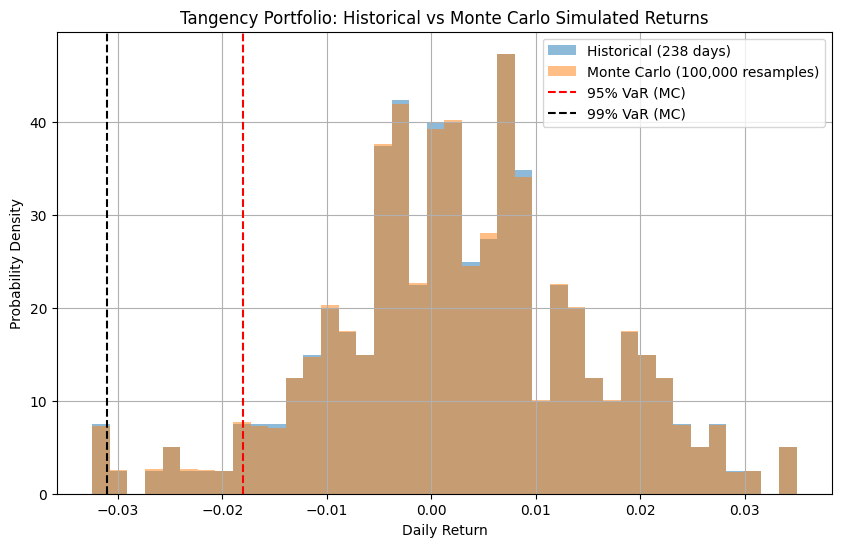

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# === 1) Historical portfolio daily returns (already computed earlier as port_ret) ===
hist_returns = port_ret.dropna().values
n = len(hist_returns)

# === 2) Monte Carlo bootstrap simulation ===
n_sims = 100_000
rng = np.random.default_rng(seed=42)

# Resample from historical returns (with replacement)
sim_returns = rng.choice(hist_returns, size=n_sims, replace=True)

# === 3) Plotting ===
plt.figure(figsize=(10,6))

# Historical distribution
plt.hist(hist_returns, bins=40, density=True, alpha=0.5, label="Historical (238 days)")

# Monte Carlo distribution
plt.hist(sim_returns, bins=40, density=True, alpha=0.5, label="Monte Carlo (100,000 resamples)")

plt.axvline(np.quantile(sim_returns, 0.05), color="red", linestyle="--", label="95% VaR (MC)")
plt.axvline(np.quantile(sim_returns, 0.01), color="black", linestyle="--", label="99% VaR (MC)")

plt.title("Tangency Portfolio: Historical vs Monte Carlo Simulated Returns")
plt.xlabel("Daily Return")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()
